In [ ]:
# word 2 vec 을 사용해 벡터라이즈, 단어의 맥락을 유지함,
#유클리디안거리,코사인유사도 방식으로 거리를 측정하고 거리가 가까울 수록 의미가 비슷하다

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타내며
delimiter = \t 는 필드가 탭으로 구분되는 것을 의미한다.
quoting = 3은 쌍따옴표를 무시하도록 한다.
"""

# 레이블인 sentiment 가 있는 학습 데이터
train = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/labeledTrainData.tsv', delimiter='\t', quoting=3)
# 레이블이 없는 테스트 데이터
test = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/testData.tsv', delimiter='\t', quoting=3)

unlabeled_train = pd.read_csv('https://github.com/corazzon/KaggleStruggle/raw/master/word2vec-nlp-tutorial/data/unlabeledTrainData.tsv', delimiter='\t', quoting=3)

train.shape, test.shape, unlabeled_train.shape

((25000, 3), (25000, 2), (50000, 2))

In [ ]:
unlabeled_train.head() # 긍정부정이 없음

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [ ]:
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from multiprocessing import Pool
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


def review_to_words( raw_review, remove_stopwords=False ):
    # 1. HTML 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. 영문자가 아닌 문자는 공백으로 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. 소문자 변환
    words = letters_only.lower().split()
    if remove_stopwords:
      stops = set(stopwords.words('english'))
      words = [w for w in words if not w in stops]

    stemmer = nltk.stem.SnowballStemmer('english') # 형태소 분석기 포터스태머
    # 6. 어간추출
    words = [stemmer.stem(w) for w in words]
    return( words )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from multiprocessing import Pool

class KaggleWord2VecUtility(object):

    @staticmethod
    def review_to_wordlist(review, remove_stopwords=False):
        # 1. HTML 제거
        review_text = BeautifulSoup(review, "html.parser").get_text()
        # 2. 특수문자를 공백으로 바꿔줌
        review_text = re.sub('[^a-zA-Z]', ' ', review_text)
        # 3. 소문자로 변환 후 나눈다.
        words = review_text.lower().split()
        # 4. 불용어 제거
        if remove_stopwords:
            stops = set(stopwords.words('english'))
            words = [w for w in words if not w in stops]
        # 5. 어간추출
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]
        # 6. 리스트 형태로 반환
        return(words)

    @staticmethod
    def review_to_join_words( review, remove_stopwords=False ):
        words = KaggleWord2VecUtility.review_to_wordlist(\
            review, remove_stopwords=False)
        join_words = ' '.join(words)
        return join_words

    @staticmethod
    def review_to_sentences( review, remove_stopwords=False ):
        # punkt tokenizer를 로드한다.
        """
        이 때, pickle을 사용하는데
        pickle을 통해 값을 저장하면 원래 변수에 연결 된 참조값 역시 저장된다.
        저장된 pickle을 다시 읽으면 변수에 연결되었던
        모든 레퍼런스가 계속 참조 상태를 유지한다.
        """
        tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        # 1. nltk tokenizer를 사용해서 단어로 토큰화 하고 공백 등을 제거한다.
        raw_sentences = tokenizer.tokenize(review.strip())
        # 2. 각 문장을 순회한다.
        sentences = []
        for raw_sentence in raw_sentences:
            # 비어있다면 skip
            if len(raw_sentence) > 0:
                # 태그제거, 알파벳문자가 아닌 것은 공백으로 치환, 불용어제거
                sentences.append(\
                    KaggleWord2VecUtility.review_to_wordlist(\
                    raw_sentence, remove_stopwords))
        return sentences


    # 참고 : https://gist.github.com/yong27/7869662
    # http://www.racketracer.com/2016/07/06/pandas-in-parallel/
    # 속도 개선을 위해 멀티 스레드로 작업하도록
    @staticmethod
    def _apply_df(args):
        df, func, kwargs = args
        return df.apply(func, **kwargs)

    @staticmethod
    def apply_by_multiprocessing(df, func, **kwargs):
        # 키워드 항목 중 workers 파라메터를 꺼냄
        workers = kwargs.pop('workers')
        # 위에서 가져온 workers 수로 프로세스 풀을 정의
        pool = Pool(processes=workers)
        # 실행할 함수와 데이터프레임을 워커의 수 만큼 나눠 작업
        result = pool.map(KaggleWord2VecUtility._apply_df, [(d, func, kwargs)
                for d in np.array_split(df, workers)])
        pool.close()
        # 작업 결과를 합쳐서 반환
        return pd.concat(result)

In [ ]:
len(review_to_words(train['review'][0]))

437

In [ ]:
train['review']

0        "With all this stuff going down at the moment ...
1        "\"The Classic War of the Worlds\" by Timothy ...
2        "The film starts with a manager (Nicholas Bell...
3        "It must be assumed that those who praised thi...
4        "Superbly trashy and wondrously unpretentious ...
                               ...                        
24995    "It seems like more consideration has gone int...
24996    "I don't believe they made this film. Complete...
24997    "Guy is a loser. Can't get girls, needs to bui...
24998    "This 30 minute documentary Buñuel made in the...
24999    "I saw this movie as a child and it broke my h...
Name: review, Length: 25000, dtype: object

In [ ]:
# 배열 담기

In [ ]:
nltk.download('punkt')

sentences = []
for review in train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [ ]:
for review in unlabeled_train["review"]:
    sentences += KaggleWord2VecUtility.review_to_sentences(
        review, remove_stopwords=False)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packa

In [ ]:
len(sentences)

795538

In [ ]:
sentences[0][:10]

['with', 'all', 'this', 'stuff', 'go', 'down', 'at', 'the', 'moment', 'with']

In [ ]:
sentences[1][:10]

['mayb', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into']

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

In [ ]:
# Word2Vec 모델의 파라메터
# 아키텍처 : 아키텍처 옵션은 skip-gram (default) 또는 CBOW 모델이다. skip-gram (default)은 느리지 만 더 나은 결과를 낸다.

# 학습 알고리즘 : Hierarchical softmax (default) 또는 negative 샘플링. 여기에서는 기본값이 잘 동작한다.

# 빈번하게 등장하는 단어에 대한 다운 샘플링 : Google 문서는 .00001에서 .001 사이의 값을 권장한다. 여기에서는 0.001에 가까운 값이 최종 모델의 정확도를 높이는 것으로 보여진다.

# 단어 벡터 차원 : 많은 feature를 사용한다고 항상 좋은 것은 아니지만 대체적으로 좀 더 나은 모델이 된다. 합리적인 값은 수십에서 수백 개가 될 수 있고 여기에서는 300으로 지정했다.

# 컨텍스트 / 창 크기 : 학습 알고리즘이 고려해야하는 컨텍스트의 단어 수는 얼마나 될까? hierarchical softmax 를 위해 좀 더 큰 수가 좋지만 10 정도가 적당하다.

# Worker threads : 실행할 병렬 프로세스의 수로 컴퓨터마다 다르지만 대부분의 시스템에서 4에서 6 사이의 값을 사용하다.

# 최소 단어 수 : 어휘의 크기를 의미있는 단어로 제한하는 데 도움이 된다. 모든 문서에서이 여러 번 발생하지 않는 단어는 무시된다. 10에서 100 사이가 적당하며, 이 경진대회의 데이터는 각 영화가 30개씩의 리뷰가 있기 때문에 개별 영화 제목에 너무 많은 중요성이 붙는 것을 피하기 위해 최소 단어 수를 40으로 설정한다. 그 결과 전체 어휘 크기는 약 15,000 단어가 된다. 높은 값은 제한 된 실행시간에 도움이 된다.

In [ ]:
# 파라메터값 지정
num_features = 300 # 문자 벡터 차원 수
min_word_count = 40 # 최소 문자 수
num_workers = 4 # 병렬 처리 스레드 수
context = 10 # 문자열 창 크기
downsampling = 1e-3 # 문자 빈도 수 Downsample

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context,
                          sample=downsampling)
model

2022-01-27 12:20:59,488 : INFO : collecting all words and their counts
2022-01-27 12:20:59,494 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-27 12:20:59,682 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 12465 word types
2022-01-27 12:20:59,897 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 17070 word types
2022-01-27 12:21:00,128 : INFO : PROGRESS: at sentence #30000, processed 671314 words, keeping 20370 word types
2022-01-27 12:21:00,249 : INFO : PROGRESS: at sentence #40000, processed 897814 words, keeping 23125 word types
2022-01-27 12:21:00,480 : INFO : PROGRESS: at sentence #50000, processed 1116962 words, keeping 25365 word types
2022-01-27 12:21:00,689 : INFO : PROGRESS: at sentence #60000, processed 1338403 words, keeping 27283 word types
2022-01-27 12:21:00,820 : INFO : PROGRESS: at sentence #70000, processed 1561579 words, keeping 29024 word types
2022-01-27 12:21:00,932 : INFO : PROGRESS: 

In [ ]:
# 학습이 완료 되면 필요없는 메모리를 unload 시킨다.
model.init_sims(replace=True)

model_name = '300features_40minwords_10text'
# model_name = '300features_50minwords_20text'
model.save(model_name)

2022-01-27 12:25:41,716 : INFO : precomputing L2-norms of word weight vectors
2022-01-27 12:25:41,833 : INFO : saving Word2Vec object under 300features_40minwords_10text, separately None
2022-01-27 12:25:41,836 : INFO : not storing attribute vectors_norm
2022-01-27 12:25:41,839 : INFO : not storing attribute cum_table
2022-01-27 12:25:42,232 : INFO : saved 300features_40minwords_10text


In [ ]:
# 유사도가 없는 단어 추출
model.wv.doesnt_match('man woman child kitchen'.split())

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'kitchen'

['man', 'woman', 'child', 'kitchen']

In [ ]:
model.wv.doesnt_match("france england germany berlin".split())

2022-01-27 12:25:55,744 : WARNING : vectors for words {'france', 'germany'} are not present in the model, ignoring these words
/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'berlin'

In [ ]:
# 가장 유사한 단어를 추출
model.wv.most_similar("man")

[('woman', 0.6337493062019348),
 ('millionair', 0.5218256115913391),
 ('lad', 0.505902886390686),
 ('businessman', 0.5051427483558655),
 ('ladi', 0.4979287385940552),
 ('widow', 0.47199350595474243),
 ('men', 0.4599936902523041),
 ('farmer', 0.4585924744606018),
 ('loner', 0.4553702175617218),
 ('gunman', 0.45320284366607666)]

In [ ]:
%%bash
apt-get update
pip3 install JPype1
pip3 install konlpy

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:13 https://developer.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7fe16decad10>)

In [ ]:
train_data = pd.read_table('ratings.txt')

In [ ]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

2022-01-27 12:32:46,513 : INFO : NumExpr defaulting to 2 threads.


False


In [ ]:
# 전처리
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in (train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화 # 텍스트를 형태소 단위로 나눈다.
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


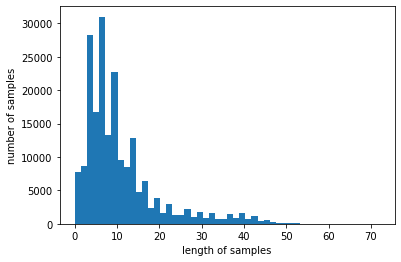

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

2022-01-27 13:14:13,845 : INFO : collecting all words and their counts
2022-01-27 13:14:13,849 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-27 13:14:13,892 : INFO : PROGRESS: at sentence #10000, processed 103893 words, keeping 11534 word types
2022-01-27 13:14:13,931 : INFO : PROGRESS: at sentence #20000, processed 210455 words, keeping 16574 word types
2022-01-27 13:14:13,970 : INFO : PROGRESS: at sentence #30000, processed 314404 words, keeping 20052 word types
2022-01-27 13:14:14,012 : INFO : PROGRESS: at sentence #40000, processed 418553 words, keeping 22857 word types
2022-01-27 13:14:14,054 : INFO : PROGRESS: at sentence #50000, processed 522738 words, keeping 25403 word types
2022-01-27 13:14:14,097 : INFO : PROGRESS: at sentence #60000, processed 627916 words, keeping 27650 word types
2022-01-27 13:14:14,140 : INFO : PROGRESS: at sentence #70000, processed 733008 words, keeping 29597 word types
2022-01-27 13:14:14,185 : INFO : PROGRESS: at 

In [ ]:
model.wv.vectors.shape

(16477, 100)

In [ ]:
print(model.wv.most_similar("최민식"))

2022-01-27 13:15:10,742 : INFO : precomputing L2-norms of word weight vectors


[('김명민', 0.8561480045318604), ('안성기', 0.8529692888259888), ('한석규', 0.8519237041473389), ('미스캐스팅', 0.8461310863494873), ('이정재', 0.841224193572998), ('최민수', 0.8379496335983276), ('신인', 0.8322809934616089), ('송강호', 0.8282245397567749), ('이주승', 0.8258365988731384), ('황정민', 0.8257161378860474)]


In [ ]:
model.save('/content/drive/MyDrive/NPL/MyWord2vec.bin')

2022-01-27 13:17:16,774 : INFO : saving Word2Vec object under /content/drive/MyDrive/NPL/MyWord2vec.bin, separately None
2022-01-27 13:17:16,779 : INFO : not storing attribute vectors_norm
2022-01-27 13:17:16,781 : INFO : not storing attribute cum_table
2022-01-27 13:17:17,162 : INFO : saved /content/drive/MyDrive/NPL/MyWord2vec.bin


In [ ]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/NPL/MyWord2vec.pkl')

['/content/drive/MyDrive/NPL/MyWord2vec.pkl']

',ㄱ'

# 나만의 word2vec

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
# 파일 불러보기
loaded_model = joblib.load('/content/drive/MyDrive/NPL/MyWord2vec.pkl')


In [ ]:
loaded_model.wv.most_similar(positive=['르브론'])

[('신발', 0.987055778503418),
 ('농구', 0.9814304113388062),
 ('조던', 0.9765362739562988),
 ('화', 0.9758518934249878),
 ('스니커', 0.9725878238677979),
 ('타격', 0.21992114186286926),
 ('삭발', 0.214054673910141),
 ('토이', 0.19997797906398773),
 ('류현진', 0.19388997554779053),
 ('양반', 0.19026854634284973)]

In [ ]:
li = [
     '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
       '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커','농구화 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '신발 조던 르브론 농구 스니커',
      '조던 르브론 농구 스니커',
]

In [ ]:
from gensim.models import Word2Vec

def makeToken(li):
  stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
  # 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
  okt = Okt()

  tokenized_data = []
  for sentence in li:
      tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화 # 텍스트를 형태소 단위로 나눈다.
      stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
      tokenized_data.append(stopwords_removed_sentence)

  return tokenized_data


def LetsTrain(model,tokenized_data):
  # model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
  # model.train(sentences,total_examples=model.corpus_count,epochs=model.iter)
  model_2 = Word2Vec(size=300, min_count=1) # 새로운 단어를 학습할 모델
  model_2.build_vocab(tokenized_data) # 단어 추가
  model_2.build_vocab([list(model.wv.vocab.keys())], update=True) # 기존 모델과 합침
  model_2.train(tokenized_data, total_examples= model_2.corpus_count, epochs=model_2.iter) # 훈련

  return model_2


In [ ]:
token = makeToken(li)
token[:10], len(token)

([['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커'],
  ['신발', '조던', '르브론', '농구', '스니커']],
 112)

In [ ]:
plzModel = LetsTrain(loaded_model,token)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


In [ ]:
plzModel.wv.most_similar(positive=['감동'])

[('카리스마', 0.23418517410755157),
 ('표시', 0.21633443236351013),
 ('찍지마라', 0.20859844982624054),
 ('알리샤', 0.20551899075508118),
 ('만족스럽다', 0.20415033400058746),
 ('점준', 0.20380525290966034),
 ('따라다니다', 0.20309239625930786),
 ('사시', 0.20063839852809906),
 ('어투', 0.19270800054073334),
 ('수탈', 0.19101575016975403)]

In [ ]:
len(loaded_model.wv.vocab), len(plzModel.wv.vocab) # 들어간 단어수 확인

(16477, 16479)

In [ ]:
# 저장
import joblib
joblib.dump(plzModel, '/content/drive/MyDrive/NPL/MyWord2vec.pkl')


['/content/drive/MyDrive/NPL/MyWord2vec.pkl']

# 시행착오

In [ ]:
import joblib
from gensim.models import Word2Vec, KeyedVectors
# 파일 불러보기
# loaded_model = joblib.load('/content/drive/MyDrive/NPL/MyWord2vec.pkl')
modelPlz = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/NPL/MyKoModel', binary=False, encoding='utf-8')


In [ ]:
len(modelPlz.wv.vocab), len(model_2.wv.vocab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


(16477, 16479)

In [ ]:
model_2 = Word2Vec(size=300, min_count=1) # 새로운 단어를 학습할 모델
model_2.build_vocab(token) # 단어 추가
model_2.build_vocab([list(loaded_model.wv.vocab.keys())], update=True) # 기존 모델과 합침

In [ ]:
# model_2.build_vocab([list(loaded_model.wv.vocab.keys())], update=True)
# model_2.intersect_word2vec_format("/content/drive/MyDrive/NPL/MyKoModel", binary=False)
#   Merge the input-hidden weight matrix from the original word2vec-tool format given, where it intersects with the current vocabulary.
#   (No words are added to the existing vocabulary, but intersecting words adopt the file’s weights, and non-intersecting words are left alone.)
model_2.train(token, total_examples= model_2.corpus_count, epochs=model_2.iter)

# 안됨.. 인코딩문제??


ValueError: ignored

In [ ]:
model_2.wv.most_similar('르브론') # 단어 등록 완료확인

[('썩을', 0.20377802848815918), ('서브', 0.1986670047044754), ('재임', 0.19817489385604858), ('느끼하다', 0.1948268711566925), ('매도', 0.1903342604637146), ('타이어', 0.18985819816589355), ('잘맞다', 0.1872764229774475), ('오래', 0.1867975890636444), ('땅콩', 0.1866961419582367), ('뿐이다', 0.18474434316158295)]


In [ ]:
model_2.train(token, total_examples= model_2.corpus_count, epochs=model_2.iter) # 훈련

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(3769, 4905)

In [ ]:
model_2.wv.most_similar('르브론') # 성공!

[('농구', 0.9973356127738953),
 ('신발', 0.9962156414985657),
 ('사다', 0.9949896335601807),
 ('사람', 0.9627845287322998),
 ('화', 0.9470525979995728),
 ('싶다', 0.9204604625701904),
 ('나', 0.8815547823905945),
 ('보다', 0.8606065511703491),
 ('발사', 0.8594789505004883),
 ('신', 0.8580775856971741)]